# Import required python package and set the Cloudant credentials
flightPredict is a helper package used to load data into RDD of LabeledPoint

In [1]:
%matplotlib inline
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from numpy import array
import numpy as np
import math
!pip install --user --upgrade -e https://github.com/ibm-cds-labs/simple-data-pipe-connector-flightstats/raw/master/lib/python/flightPredict/dist/flightPredict-0.3.tar.gz
import flightPredict
flightPredict.sqlContext = sqlContext
flightPredict.cloudantHost='XXX'
flightPredict.cloudantUserName='XXX'
flightPredict.cloudantPassword='XXX'
flightPredict.weatherUrl='XXX'

The directory '/Users/dtaieb/Library/Caches/pip/http' or its parent directory is not owned by the current user and the cache has been disabled. Please check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
The directory '/Users/dtaieb/Library/Caches/pip' or its parent directory is not owned by the current user and caching wheels has been disabled. check the permissions and owner of that directory. If executing pip with sudo, you may want sudo's -H flag.
Processing /Users/dtaieb/watsondev/workspaces/cds_workspace/pipes-connector-flightstats/lib/python/flightPredict
  Running setup.py install for flightPredict ... - \ done


# load data from training data set and print the schema

In [2]:
dbName = "<your db training set here>"
cloudantdata = flightPredict.loadDataSet(dbName,"training")
cloudantdata.cache()
cloudantdata.printSchema()
cloudantdata.count()

Successfully registered SQL table training
root
 |-- _id: string (nullable = true)
 |-- _rev: string (nullable = true)
 |-- actualRunwayArrival: struct (nullable = true)
 |    |-- dateLocal: string (nullable = true)
 |    |-- dateUtc: string (nullable = true)
 |-- actualRunwayDeparture: struct (nullable = true)
 |    |-- dateLocal: string (nullable = true)
 |    |-- dateUtc: string (nullable = true)
 |-- arrivalAirportFsCode: string (nullable = true)
 |-- arrivalTerminal: string (nullable = true)
 |-- arrivalTime: string (nullable = true)
 |-- arrivalWeather: struct (nullable = true)
 |    |-- blunt_phrase: string (nullable = true)
 |    |-- class: string (nullable = true)
 |    |-- clds: string (nullable = true)
 |    |-- day_ind: string (nullable = true)
 |    |-- dewPt: long (nullable = true)
 |    |-- expire_time_gmt: long (nullable = true)
 |    |-- feels_like: long (nullable = true)
 |    |-- gust: string (nullable = true)
 |    |-- heat_index: long (nullable = true)
 |    |-- ic

1498

# Visualize classes in scatter plot based on 2 features 

/Users/dtaieb/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


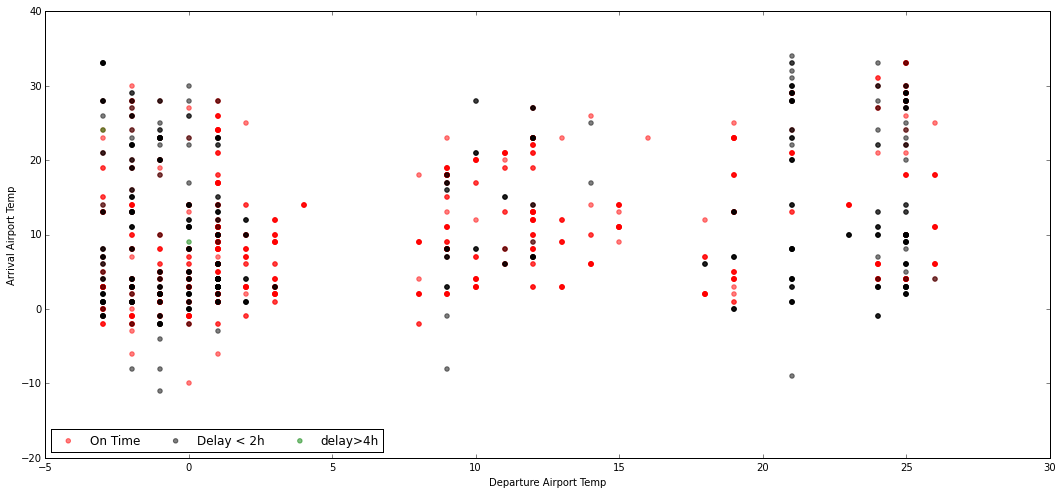

In [4]:
flightPredict.scatterPlotForFeatures(cloudantdata, \
     "departureWeather.temp","arrivalWeather.temp","Departure Airport Temp", "Arrival Airport Temp")

/Users/dtaieb/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


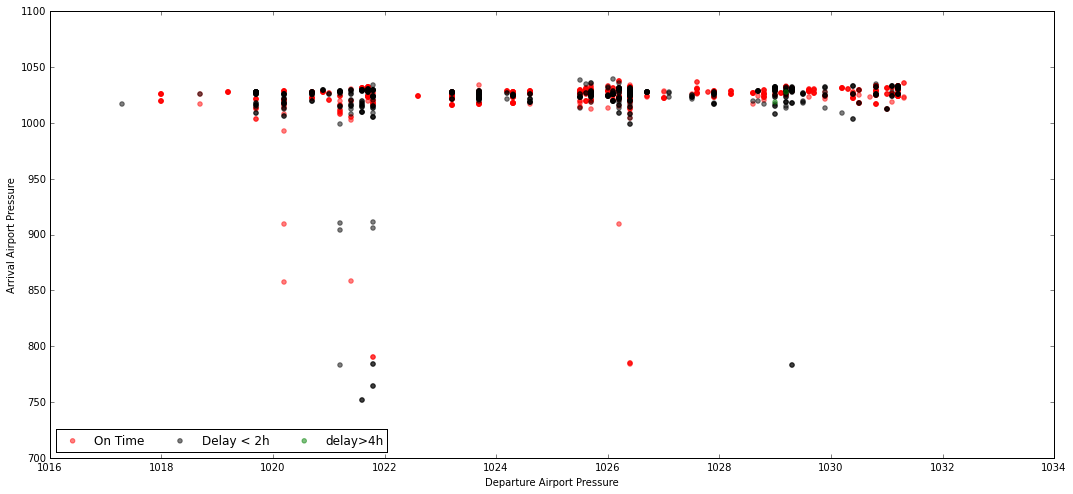

In [17]:
flightPredict.scatterPlotForFeatures(cloudantdata,\
     "departureWeather.pressure","arrivalWeather.pressure","Departure Airport Pressure", "Arrival Airport Pressure")

/Users/dtaieb/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


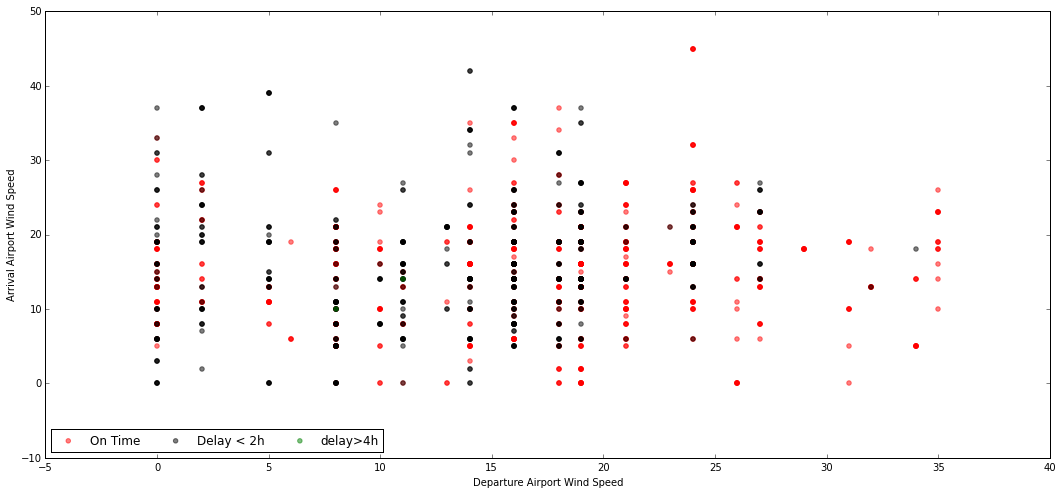

In [18]:
flightPredict.scatterPlotForFeatures(cloudantdata,\
 "departureWeather.wspd","arrivalWeather.wspd","Departure Airport Wind Speed", "Arrival Airport Wind Speed")

# Load the training data as an RDD of LabeledPoint

In [5]:
trainingData = flightPredict.loadLabeledDataRDD("training")
print(trainingData)

PythonRDD[40] at RDD at PythonRDD.scala:43


# Train multiple classification models

In [6]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
logRegModel = LogisticRegressionWithLBFGS.train(trainingData.map(lambda lp: LabeledPoint(lp.label,\
      np.fromiter(map(lambda x: 0.0 if np.isnan(x) else x,lp.features.toArray()),dtype=np.double )))\
      , iterations=100, validateData=False, intercept=True)
print(logRegModel)

(weights=[0.00213085297332,0.047078854988,0.424717426924,0.00223498397915,0.00217208955158,0.0185950851104,0.00222974705758,0.105884922595,-0.000322760163309,0.00697533838812,0.0487071177023,0.00577984380965,0.00113624741676,0.0172413809888,0.0055698496828,0.047388431319], intercept=1.0802674829994217)


In [7]:
from pyspark.mllib.classification import NaiveBayes
#NaiveBayes requires non negative features, set them to 0 for now
modelNaiveBayes = NaiveBayes.train(trainingData.map(lambda lp: LabeledPoint(lp.label, \
                    np.fromiter(map(lambda x: x if x>0.0 else 0.0,lp.features.toArray()),dtype=np.int)\
               ))\
          )

print(modelNaiveBayes)

In [9]:
from pyspark.mllib.tree import DecisionTree
modelDecisionTree = DecisionTree.trainClassifier(trainingData.map(lambda lp: LabeledPoint(lp.label,\
      np.fromiter(map(lambda x: 0.0 if np.isnan(x) else x,lp.features.toArray()),dtype=np.double )))\
      , numClasses=5, categoricalFeaturesInfo={})
print(modelDecisionTree)

DecisionTreeModel classifier of depth 5 with 55 nodes


In [11]:
from pyspark.mllib.tree import RandomForest
modelRandomForest = RandomForest.trainClassifier(trainingData.map(lambda lp: LabeledPoint(lp.label,\
      np.fromiter(map(lambda x: 0.0 if np.isnan(x) else x,lp.features.toArray()),dtype=np.double )))\
      , numClasses=5, categoricalFeaturesInfo={},numTrees=100)
print(modelRandomForest)

TreeEnsembleModel classifier with 100 trees



# Load Blind data from Cloudant database

In [14]:
dbTestName="<Your db test set here>"
testCloudantdata = flightPredict.loadDataSet(dbTestName,"test")
testCloudantdata.count()

Successfully registered SQL table test


104

In [15]:
testData = flightPredict.loadLabeledDataRDD("test")
flightPredict.runMetrics(trainingData,modelNaiveBayes,modelDecisionTree,logRegModel,modelRandomForest)

Model,Accuracy,Precision,Recall
NaiveBayesModel,33.20%,72.62%,24.63%
DecisionTreeModel,71.34%,73.21%,71.23%
LogisticRegressionModel,41.07%,33.39%,53.34%
RandomForestModel,66.39%,69.59%,68.69%


# Run the predictive model
runModel(departureAirportCode, departureDateTime, arrivalAirportCode, arrivalDateTime)  
Note: all DateTime must use UTC format

In [16]:
from flightPredict import run
run.useModels(modelNaiveBayes,modelDecisionTree,logRegModel,modelRandomForest)
run.runModel('BOS', "2016-02-08 20:15-0500", 'LAX', "2016-01-08 22:30-0500" )

Logan International Airport,Prediction,Los Angeles International Airport
Forecast: Snow/WindDew Point: -9Relative Humidity: 67Prevailing Hourly visibility: 1.6Wind Chill: -12Wind direction: 350Wind Speed: 34Feels Like Temperature: -12Hourly Maximum UV Index: 0,NaiveBayesModel: Delayed more than 4 hoursDecisionTreeModel: Delayed less than 2 hoursLogisticRegressionModel: On TimeRandomForestModel: On Time,Forecast: ClearDew Point: 3Relative Humidity: 30Prevailing Hourly visibility: 16.1Wind Chill: 21Wind direction: 331Wind Speed: 6Feels Like Temperature: 21Hourly Maximum UV Index: 0
